# Практическое задание

## Интерполяция байеровского шаблона (demosaicing)

### О задании

В этом задании вам предстоит познакомится с простейшими инструментами считывания и обработки изображений в python, и с помощью них реализовать и протестировать 2 метода интерполяции байеровского шаблона. 

### Инструменты

Задание предполагает использование `python3`, не ниже версии `3.5`. 
Вам понадобится работать со следущими пакетами:

* [`numpy`](https://docs.scipy.org/doc/numpy/reference/index.html) - библиотека для работы с многомерными масивами и матрицами, содержащая большое кол-во высокоуровневых математических функций для операций с этими масивами.  


* [`skimage`](http://scikit-image.org/) - библиотека, содержащие большую коллекцию алгоритмов для обработки изображений;

* [`scipy`](https://www.scipy.org/) - библиотека, содержащая большой набор инструментов для математических и инженерных вычислений. Основная структура данных numpy массив.

* [`matplotlib`](https://matplotlib.org/) - библиотека для визуализации различных графиков, диаграмм, изображений и много другого.

In [1]:
#!pip install numpy scikit-image scipy matplotlib

### Общая информация

Фильтр Байера - это матрица цветных фильтров для фотосенсора фотоаппарта. Каждая ячейка матрицы представляет собой фильтр одного из цветов R, G или B. В классическом фильтре Байера применяются светофильтры трёх основных цветов в следующем порядке: <img src="bayer_pat.png" width="50">
Матрица является устройством, воспринимающим спроецированное на него изображение. Вследствие использования фильтров каждый фотоприемник воспринимает лишь 1/3 цветовой информации участка изображения, а 2/3 отсекается фильтром. Недостающие компоненты цвета рассчитываются процессором камеры на основании данных из соседних ячеек в результате интерполяции (demosaicing).
<img src="bayer.jpg" width="500">

Вам необходимо будет научиться востанавливать "полноцветное" изображение по байеровскому шаблону.

Вместе с заданием вам был выдан архив `data.zip`. В нем содержатся следущие данные:
* `raw/` - директория с  различными одноканальными изображениями, полученными с помощью фильтра Байера. Фильтр Байера который применялся, соответствует последовательности каналов(GRGB), показанной выше. В каждом пикселе изображения записан отклик фильтра соответсвующего цвета;
* `gt/` - директория с *ground truth* изображениями, каждому raw-изображению из предыдущей директории существует изображение из этой директории(с тем же именем) с истинными значениями RGB-канналов в каждом пикселе;
* `debug/` - изображения для самопроверки работы алгоритмов.

Выполненный нотбук сдается вместе с папкой `results`, где должны лежать результаты работы алгоритмов. Ниже будет описано подробнее. Все необходимо заархивировать в один zip файл.

### Практическая часть

In [1]:
import skimage.io
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
GT_DIR = 'data/gt/'
RAW_DIR = 'data/raw/'

**1. (0.5 балла)**

Считайте raw и ground truth изображения `IMG0001.bmp`, выведите в какой тип данных они считались(список, массив, ...?), какой тип данных у пикселей изображения(float, int, ...?), размеры изображений.  Подумайте на тем как хранятся изображения в памяти.

Вам могут понадобиться:
* `skimage.io.imread(..)`

**Hint**: в jupyter-notebook если после ввода названия функции нажать сочетание клавиш `shift+tab` , выведется докстринг этой функции.

In [4]:
gt_image = skimage.io.imread(GT_DIR + 'IMG0001.bmp')
raw_image = skimage.io.imread(RAW_DIR + 'IMG0001.bmp')

print("Тип считанного изображения:", type(gt_image))
print('Типы элементов матриц:', gt_image.dtype)
print("Размеры:", gt_image.size, raw_image.size)

Тип считанного изображения: <class 'numpy.ndarray'>
Типы элементов матриц: uint8
Размеры: 1179648 393216


Теперь давайте посмотрим на считанные изображения. Для этого воспользуемся:
* `matplotlib.pyplot.subplots(...)` для создания фигуры, заданного размера, с нужным нам количеством окон
* `matplotlib.axes.Axes.imshow(...)` методом объекта `matplotlib.axes.Axes` для вывода изображения

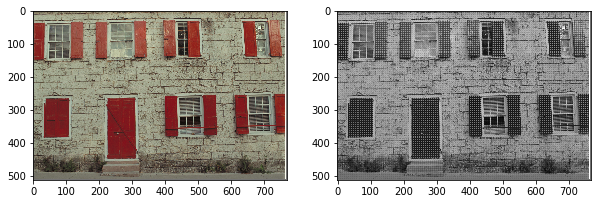

In [5]:
figure, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(gt_image)
axs[1].imshow(raw_image, cmap='gray')
plt.show()

**2. (0.5 балла)**

Перейдем непосредственного к интерепполяции байеровского шаблона.
Напишите вспомогательную функцию, которая для заданного размера raw-изображения создает маски для красных, зеленых и синих каналов байровского шаблона.

Вам могут понадобиться:
* `numpy.tile(...)`

In [8]:
def get_bayer_pattern_masks(h, w):
    """
    Get 3 masks for red, green, blue channels of bayer pattern size (h, w)

    :param h: int, height of bayer pattern
    :param w: int, width of bayer pattern
    :return: [numpy.ndarray((h, w)), numpy.ndarray((h, w)), numpy.ndarray((h, w))],
    list of 3 mask, size (h, w) for red, green, blue channels respectively
    """
    red = np.tile(np.array([[0, 1], [0, 0]]), (h // 2 + h % 2, w // 2 + w % 2))
    green = np.tile(np.array([[1, 0], [0, 1]]), (h // 2 + h % 2, w // 2 + w % 2))
    blue = np.tile(np.array([[0, 0], [1, 0]]), (h // 2 + h % 2, w // 2 + w % 2))
    if h % 2:
        red = np.delete(red, (h), axis=0)
        red = np.delete(red, (w), axis=1)
        green = np.delete(green, (h), axis=0)
        green = np.delete(green, (w), axis=1)
        blue = np.delete(blue, (h), axis=0)
        blue = np.delete(blue, (w), axis=1)
    return red, green, blue

Проверьте правильность работы  функции с помощью простейшего теста.

In [4]:
# small test for self-examination
r, g, b = get_bayer_pattern_masks(3, 3) 
assert (r == np.array([
    [0, 1, 0], 
    [0, 0, 0], 
    [0, 1, 0]]
)).all()
assert (g == np.array([
    [1, 0, 1], 
    [0, 1, 0], 
    [1, 0, 1]]
)).all()
assert (b == np.array([
    [0, 0, 0], 
    [1, 0, 1], 
    [0, 0, 0]]
)).all()

**3. (0.5 балла)**

Посмотрим, что на самом деле хранится в raw-изображениях. Напишите функцию, которая создает цветное изображение из raw-изображения следущим образом: в каждый цветовой канал поместите только известные пиксели из raw-изображения, пиксели, в которых данный цвет неизвестен, поставьте 0. Сохраните данное изображение в файл `results/colored_raw_image.bmp` и посмотрите что получилось.

Вам может пригодиться:
* `np.where(...)`
* `skimage.io.imsave(...)`

In [5]:
def get_colored_raw_image(raw_image):
    """
    Create colored raw image.
    
    :param raw_image: numpy.ndarray((h, w), dtype=np.uint8), raw image created with bayer pattern
    :return: numpy.ndarray((h, w, 3), dtype=np.uint8), colored raw image
    """
    
    h = raw_image.shape[0]
    w = raw_image.shape[1]
    r, g, b = get_bayer_pattern_masks(h, w)
    colored_raw_image = np.array([r * raw_image, g * raw_image, b * raw_image])
    colored_raw_image = np.swapaxes(colored_raw_image, 0, 1)
    colored_raw_image = np.swapaxes(colored_raw_image, 1, 2)
    
    return colored_raw_image

In [6]:
colored_raw_image = get_colored_raw_image(raw_image)
print(colored_raw_image.shape)
os.makedirs('results/', exist_ok=True)

skimage.io.imsave('results/colored_raw_image.bmp', colored_raw_image)

(512, 768, 3)


/home/alexander/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/home/alexander/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: results/colored_raw_image.bmp is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/alexander/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/home/alexander/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


**4. (3 балла)**

Напишите алгоритм билинейной интерполяции байеровского шаблона. В этом алгоритме **неизвестные** значения цветовых компонент вычисляются следущим образом:
* рассматривается окно 3x3 с центром в данном пикселе
* значение цветовой компоненты(r, g, или b) в данном пикселе вычисляется как среднее **заданных** значений данной цветовой компоненты пикселей в этом окне

Например, если, мы хотим интерполировать значение зеленой компоненты цвета в пикселе отмеченном '$+$' на рисунке, нам необходимо усреднить значение 4-х зеленых конпонент в 3x3 окрестности, отмеченных '$\cdot$' 

<img src="example.png" width="130">

В данном задание разрешается обходить матрицу и попиксельно вычислять цветовые компоненты. На будущих занятих вы познакомитесь с понятием "cвертка", и узнаете как на питоне можно было бы избежать обхода матрицы.

Вам может пригодиться:
* `numpy.stack(...)`
* `numpy.rint(...)`

**Замечания:** 
* Поведение на границе, где окно 3x3 неполное, выберите на свое усмотрение, при подсчете метрик оно учитываться не будет.
* Выполнение алгоритма на одном изображении не должно занимать более 20 секунд.
* Будьте аккуратны с вычислениями, raw-изображние хранит `uint8` значения. Для избежания ошибок, связанных с переполнением типа и округлением, рекомендуется в самом начале вычислений преобразовывать изображения в тип `float64`, а после окончания округлять значения до целых с помощью `numpy.rint(...)` и преобразовывать тип обратно в `uint8`.

In [43]:
def bilinear_interpolation(raw_image):
    """
    Perform bilinear interpolation demosaicing algorithm on raw image
    
    :param raw_image: numpy.ndarray((h, w), dtype=np.uint8), raw image created with bayer pattern
    :return: numpy.ndarray((h, w, 3), dtype=np.uint8), interpolated image
    """
    h = raw_image.shape[0]
    w = raw_image.shape[1]
    
    mask_0 = (1/4) * np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ])
    
    mask_1 = (1/4) * np.array([
        [1, 0, 1],
        [0, 0, 0],
        [1, 0, 1]
    ])
    
    mask_2 = (1/2) * np.array([
        [0, 0, 0],
        [1, 0, 1],
        [0, 0, 0]
    ])
    
    mask_3 = (1/2) * np.array([
        [0, 1, 0],
        [0, 0, 0],
        [0, 1, 0]
    ])
    
    image = np.zeros((h, w, 3), dtype=np.float64)
    for i in range(1, h-1):
        for j in range(1, w-1):
            raw_part = raw_image[i-1:i+2, j-1:j+2]
            if i%2 == 0:
                if j%2 == 0:
                    image[i][j][0] = (raw_part * mask_2).sum()
                    image[i][j][1] = raw_image[i][j]
                    image[i][j][2] = (raw_part * mask_3).sum()
                else:
                    image[i][j][0] = raw_image[i][j]
                    image[i][j][1] = (raw_part * mask_0).sum()
                    image[i][j][2] = (raw_part * mask_1).sum()
            else:
                if j%2 == 0:
                    image[i][j][0] = (raw_part * mask_1).sum()
                    image[i][j][1] = (raw_part * mask_0).sum()
                    image[i][j][2] = raw_image[i][j]
                else:
                    image[i][j][0] = (raw_part * mask_3).sum()
                    image[i][j][1] = raw_image[i][j]
                    image[i][j][2] = (raw_part * mask_2).sum()
    
    return np.rint(image).astype(np.uint8)

Проверьте правильность работы функции с помощью простейшего теста. 

In [44]:
# small test for self-examination
raw_image = skimage.io.imread('data/raw/IMG0001.bmp')
image_true = skimage.io.imread('data/debug/IMG0001_bilinear.bmp')
diff = np.abs(bilinear_interpolation(raw_image) - image_true)[1:-1, 1:-1].sum()
assert diff == 0

Вычислите билинейную интерполяцию байеровского шаблона для всех изображений из директории `raw/` и сохраните в директорию `results/bilinear/`. Посмотрите на результаты интерполяции, сделайте выводы о плюсах и минусах этого алгоритма.

In [45]:
OUTPUT_DIR = 'results/bilinear/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

for file in os.walk(RAW_DIR):
    for img_name in file[2]:
        raw_image = skimage.io.imread(RAW_DIR+img_name)
        skimage.io.imsave(OUTPUT_DIR+img_name, bilinear_interpolation(raw_image))

**Выводы:**

**5. (1 балл)**

Для численной оценки работы алгоритма билинейной интерполяции реализуйте следущие метрики качества:

* Mean squared error $mse(pred\_image, gt\_image) = \frac{1}{3 * h * w} \sum_{i=1}^{h} \sum_{j=1}^{w} \sum_{c=1}^{3} (gt\_image[i, j, c] - pred\_image[i,j,c])^2$ 

* Peak signal-to-noise ratio $psnr(pred\_image, gt\_image) = 10 \log_{10}{(\frac{max(gt\_image)^2}{mse(pred\_image, gt\_image)} )}$

где $gt\_image$ - истинное изображение, $pred\_image$ - предсказанное.

Вычислите среднее значение этих метрик для всего датасета. При подсчете метрик не учитывайте, границу изображения, длиной в 2 пикселя.

Вам может понадобиться:
* `numpy.ndarray.mean(...)`
* `numpy.ndarray.max(...)`
* `numpy.log10(...)`

**Замечание:** Будьте аккуратны с вычислениями, raw-изображние хранит `uint8` значения. Для избежания ошибок, связанных с переполнением типа, рекомендуется в самом начале вычислений преобразовать изображение в тип `float64`.

In [5]:
def mse_score(pred_image, gt_image):
    """
    Compute mean squared error
    :param pred_image: numpy.ndarray((h, w, 3), dtype=np.uint8), predicted image
    :param gt_image: numpy.ndarray((h, w, 3), dtype=np.uint8), ground truth image
    :return:
    """

    pred_image = pred_image.astype(np.float64)
    gt_image = gt_image.astype(np.float64)
    
    h = pred_image.shape[0]
    w = pred_image.shape[1]
    
    pred_image = pred_image[2:h-2, 2:w-2]
    gt_image = gt_image[2:h-2, 2:w-2]
    
    diff = (gt_image-pred_image)**2

    return np.ndarray.mean(diff)


def psnr_score(pred_image, gt_image):
    """
    Compute peak signal-to-noise ratio
    :param pred_image: numpy.ndarray((h, w, 3), dtype=np.uint8), predicted image
    :param gt_image: numpy.ndarray((h, w, 3), dtype=np.uint8), ground truth image
    :return:
    """
    pred_image = pred_image.astype(np.float64)
    gt_image = gt_image.astype(np.float64)
    
    h = pred_image.shape[0]
    w = pred_image.shape[1]
    
    mse = mse_score(pred_image, gt_image)
    
    pred_image = pred_image[2:h-2, 2:w-2]
    gt_image = gt_image[2:h-2, 2:w-2]

    return 10. * np.log10(np.ndarray.max(gt_image)**2 / mse)

In [46]:
mse_average = 0.
psnr_average = 0.
n = 0

for file in os.walk(OUTPUT_DIR):
    for img_name in sorted(file[2]):
        gt_image = skimage.io.imread(GT_DIR + img_name)
        pred_image = skimage.io.imread(OUTPUT_DIR + img_name)
        mse = mse_score(pred_image, gt_image)
        psnr = psnr_score(pred_image, gt_image)
        mse_average += mse
        psnr_average += psnr
        n += 1
        print(img_name, 'mse:', mse, 'psnr:', psnr)
        
print('\nAverage: mse:', mse_average / n, 'psnr:', psnr_average / n)

IMG0001.bmp mse: 158.87617234200437 psnr: 26.1202159264945
IMG0002.bmp mse: 53.98624537934067 psnr: 30.60115569864059
IMG0003.bmp mse: 20.574362555138723 psnr: 34.997539722970565
IMG0004.bmp mse: 34.66959966882412 psnr: 32.73131533997335
IMG0005.bmp mse: 111.4385375012024 psnr: 27.66044957015225
IMG0006.bmp mse: 89.14024388149126 psnr: 28.630065429167093
IMG0007.bmp mse: 28.187722444380316 psnr: 33.561810558662486
IMG0008.bmp mse: 198.6760505558533 psnr: 25.14934842717906
IMG0009.bmp mse: 32.67035804097786 psnr: 32.98926466846439
IMG0010.bmp mse: 26.533827005263085 psnr: 33.89280467560942
IMG0011.bmp mse: 79.56715243709719 psnr: 29.12346545134147
IMG0012.bmp mse: 20.060082313009303 psnr: 35.10747650129055
IMG0013.bmp mse: 205.1689718431793 psnr: 25.009686787760536
IMG0014.bmp mse: 73.36411997911256 psnr: 29.475966484301562
IMG0015.bmp mse: 34.87727082216817 psnr: 32.70537867211893
IMG0016.bmp mse: 57.227168961536876 psnr: 30.313010998396926
IMG0017.bmp mse: 41.83867285731954 psnr: 31.9

**6. (3.5 балла)**

Теперь реализуем более сложную версию линейной интерполяции баеровского шаблона. Прочитайте статью, выданную вам совместно с ноутбуком, и реализуйте предложенный в ней алгоритм. Вычислите интерполяцию для всех изображений и сохраните в директорию `results/improved/`. Посчитайте средние значения метрик качества. 

**Замечания по поводу алгоритма:**
* в работе указанные фильтры неотнормированны к единице(сумма коэффициентов не равняется 1), чтобы сохранить масштаб значений, коэффициенты необходимо отнормировать на сумму значений в данном фильтре;
* в результате указанных в работе фильтров могут получаться значения большие 255 и меньшие 0, вам необходимо отрезать слишком большие и слишком маленькие значения по крайним значениям(`numpy.clip`);
* веса фильтров были выписаны в массивы за вас для избежания лишних ошибок.

**Замечание:** Как никогда будьте аккуратны с вычислениями, raw-изображние хранит `uint8` значения. Для избежания ошибок, связанных с переполнением типа и округлением, рекомендуется в самом начале вычислений преобразовывать изображения в тип `float64`, а после окончания округлять значения до целых с помощью `numpy.rint(...)` и преобразовывать тип обратно в `uint8`.

In [23]:
weigths_0 = (1 / 8) * np.array([
    [ 0,  0, 1/2,  0,  0],
    [ 0, -1,   0, -1,  0],
    [-1,  4,   5,  4, -1],
    [ 0, -1,   0, -1,  0],
    [ 0,  0, 1/2,  0,  0]
])

weigths_1 = (1 / 8) * np.array([
    [  0,  0,  -1,  0,   0],
    [  0, -1,   4, -1,   0],
    [1/2,  0,   5,  0, 1/2],
    [  0, -1,   4, -1,   0],
    [  0,  0,  -1,  0,   0]
])

weigths_2 = (1 / 8) * np.array([
    [   0,  0, -3/2,  0,    0],
    [   0,  2,    0,  2,    0],
    [-3/2,  0,    6,  0, -3/2],
    [   0,  2,    0,  2,    0],
    [   0,  0, -3/2,  0,    0]
])

weigths_3 = (1 / 8) * np.array([
    [ 0,  0, -1,  0,  0],
    [ 0,  0,  2,  0,  0],
    [-1,  2,  4,  2, -1],
    [ 0,  0,  2,  0,  0],
    [ 0,  0, -1,  0,  0]
])

In [36]:
def improved_linear_interpolation(raw_image):
    """
    Improved linear interpolation demosaicing algorithm on raw image
    
    :param raw_image: numpy.ndarray((h, w), dtype=np.uint8), raw image created with bayer pattern
    :return: numpy.ndarray((h, w, 3), dtype=np.uint8), interpolated image
    """
    
    h = raw_image.shape[0]
    w = raw_image.shape[1]
    
    raw_image = raw_image.astype(np.float64)
    image = np.zeros((h, w, 3), np.float64)
    
    for i in range(2, h-2):
        for j in range(2, w-2):
            raw_part = raw_image[i-2:i+3, j-2:j+3]
            if i%2 == 0:
                if j%2 == 0:
                    image[i][j][0] = (raw_part * weigths_0).sum()
                    image[i][j][1] = raw_image[i][j]
                    image[i][j][2] = (raw_part * weigths_1).sum()
                else:
                    image[i][j][0] = raw_image[i][j]
                    image[i][j][1] = (raw_part * weigths_3).sum()
                    image[i][j][2] = (raw_part * weigths_2).sum()
            else:
                if j%2 == 0:
                    image[i][j][0] = (raw_part * weigths_2).sum()
                    image[i][j][1] = (raw_part * weigths_3).sum()
                    image[i][j][2] = raw_image[i][j]
                else:
                    image[i][j][0] = (raw_part * weigths_1).sum()
                    image[i][j][1] = raw_image[i][j]
                    image[i][j][2] = (raw_part * weigths_0).sum()
    
    np.clip(image, 0, 255, out=image)
    
    return np.rint(image).astype(np.uint8)

Проверьте правильность работы функции с помощью прmостейшего теста. 

In [37]:
# small test for self-examination
raw_image = skimage.io.imread('data/raw/IMG0001.bmp')
image_true = skimage.io.imread('data/debug/IMG0001_improved.bmp')
diff = np.abs(improved_linear_interpolation(raw_image) - image_true)[2:-2, 2:-2].sum()
assert diff == 0

In [38]:
OUTPUT_DIR2 = 'results/improved/'
os.makedirs(OUTPUT_DIR2)

for file in os.walk(RAW_DIR):
    for img_name in file[2]:
        raw_image = skimage.io.imread(RAW_DIR+img_name)
        skimage.io.imsave(OUTPUT_DIR2+img_name, improved_linear_interpolation(raw_image))

**7. (1 балл)**

Проведите сравненение двух алгоритмов. Сравните два алгоритма по метрикам качества. А также выберите сложные моменты("окна" изображениях) для интерполяции и визуализируйте эти "окна". Сравнивайте работу первого алгоритма, второго алгоритма и ground truth. Найдите 3-4 таких "окна". Сделайте выводы.

IMG0001.bmp mse: 68.3623996853142 psnr: 29.782630617665674
IMG0002.bmp mse: 56.57945386898627 psnr: 30.397399430611394
IMG0003.bmp mse: 12.608799350015802 psnr: 37.124066272280906
IMG0004.bmp mse: 26.664820120652458 psnr: 33.87141702564805
IMG0005.bmp mse: 45.39205693201962 psnr: 31.56100497711197
IMG0006.bmp mse: 37.46369432878482 psnr: 32.39469759545296
IMG0007.bmp mse: 16.027042881092743 psnr: 36.01387643446941
IMG0008.bmp mse: 89.40151468304681 psnr: 28.617354839856787
IMG0009.bmp mse: 17.157161678415854 psnr: 35.78634917061329
IMG0010.bmp mse: 13.918721915323411 psnr: 36.69481002792078
IMG0011.bmp mse: 39.19285154800676 psnr: 32.198734983463865
IMG0012.bmp mse: 10.129561398084402 psnr: 38.07489719704619
IMG0013.bmp mse: 91.94335999230462 psnr: 28.495599902392
IMG0014.bmp mse: 47.5158347762158 psnr: 31.36241997349915
IMG0015.bmp mse: 23.375161465418916 psnr: 34.44325741396157
IMG0016.bmp mse: 26.436555255527615 psnr: 33.66698496730661
IMG0017.bmp mse: 21.22034876530486 psnr: 34.863

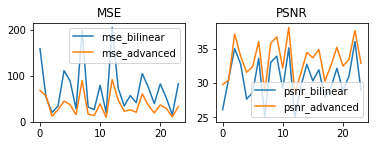

In [12]:
OUTPUT_DIR = 'results/bilinear/'
OUTPUT_DIR2 = 'results/improved/'

mse_list1 = []
psnr_list1 = []
mse_list2 = []
psnr_list2 = []

for file in os.walk(OUTPUT_DIR):
    for img_name in sorted(file[2]):
        gt_image = skimage.io.imread(GT_DIR + img_name)
        pred_image = skimage.io.imread(OUTPUT_DIR + img_name)
        mse_list1.append(mse_score(pred_image, gt_image))
        psnr_list1.append(psnr_score(pred_image, gt_image))

mse_average = 0.
psnr_average = 0.
n = 0

for file in os.walk(OUTPUT_DIR2):
    for img_name in sorted(file[2]):
        gt_image = skimage.io.imread(GT_DIR + img_name)
        pred_image = skimage.io.imread(OUTPUT_DIR2 + img_name)
        mse = mse_score(pred_image, gt_image)
        psnr = psnr_score(pred_image, gt_image)
        mse_list2.append(mse)
        psnr_list2.append(psnr)
        mse_average += mse
        psnr_average += psnr
        n += 1
        print(img_name, 'mse:', mse, 'psnr:', psnr)
        
print('\nAverage: mse:', mse_average / n, 'psnr:', psnr_average / n)

plt.subplot(2, 2, 1)
plt.plot(mse_list1, label = 'mse_bilinear')
plt.plot(mse_list2, label = 'mse_advanced')
plt.title('MSE')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(psnr_list1, label = 'psnr_bilinear')
plt.plot(psnr_list2, label = 'psnr_advanced')
plt.title('PSNR')
plt.legend()

plt.show()

**Выводы: **

In [15]:
print('Улучшенный метод обеспечивает более высокое качество интерполяции, чем билинейный метод. Однако они оба испытывают трудности на небольших объектах, таких как мелкие камни на IMG0013.bmp, забор на IMG0019.bmp, окна на IMG0008.bmp')

Улучшенный метод обеспечивает более высокое качество интерполяции, чем билинейный метод. Однако они оба испытывают трудности на небольших объектах, таких как мелкие камни на IMG0013.bmp, забор на IMG0019.bmp, окна на IMG0008.bmp
